In [4]:
pip install duckdb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.2/20.2 MB 66.7 MB/s eta 0:00:00 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


### Load data and config

In [1]:
import pandas as pd
import duckdb

def load_results(res_list):
    df_list = []
    for f in res_list:
        df = pd.read_csv(f)
        df_list.append(df)
    df = pd.concat(df_list)
    return df

def get_avg_execution_time(df):
    
    sql = """
        SELECT 
            ((max(CAST(qid AS INTEGER))+1)/3)::INTEGER as qid,
            spatial_resolution, 
            temporal_resolution,
            time_span, 
            area_persent, 
            category, 
            avg(execution_time) as avg_execution_time
        FROM df
        GROUP BY spatial_resolution, temporal_resolution, time_span, area_persent, category
        ORDER BY max(qid)
        """
    df_avg = duckdb.query(sql).to_df()

    return df_avg

def load_results_row_swap(res_list):
    df_avg = load_results(res_list=res_list)
    # adding 3yr point for temporal resolution
    last_row = df_avg.iloc[-1:]
    df_final = df_avg.iloc[:-1]
    df_final = pd.concat([df_avg.iloc[:5], last_row, df_avg.iloc[5:-1]], ignore_index=True)
    
    return df_final

def load_find_time_results(res_list):
    df_list = []
    for f in res_list:
        df = pd.read_csv(f)
        df_list.append(df)
    df = pd.concat(df_list)

    sql = """
        SELECT 
            ((max(qid)+1)/3)::integer as qid, 
            category, 
            time_span,
            filter_value,
            avg(execution_time) as avg_execution_time
        FROM df
        GROUP BY category, time_span, filter_value
        ORDER BY max(qid)
        """
    df_avg = duckdb.query(sql).to_df()
    return df_avg


Import config

In [2]:
import json
json_file = "/data/experiment-kit/experiment/results/config.json"
with open(json_file, "r") as f:
    cj = json.load(f)

### Read in data

In [3]:
# import glob

# systems_list = ["proposed", "vanilla", "cloud", "tiledb"]
# queries_list = ["raster", "heatmap", "findtime"]

# ls = []
# # read in all 
# for s in systems_list:
#     for q in queries_list:
#         cur_glob = glob.glob(cj[s][q])
#         cur_df = load_results(cur_glob)

In [4]:
import glob
polaris_list = glob.glob("/data/experiment-kit/newGetRasExp0226/proposed_GR_result_*.csv")
df_polaris_all = load_results(polaris_list)

vanilla_list = glob.glob("/data/experiment-kit/newGetRasExp0226/vanilla_GR_result_*-*.csv")
df_vanilla_all = load_results(vanilla_list)

tdb_list = glob.glob("/data/experiment-kit/newGetRasExp0226/tdb_GR_result_*-*.csv")
df_tdb_all = load_results(tdb_list)
df_tdb_all

,qid,variable,start_time,end_time,min_lat,max_lat,min_lon,max_lon,spatial_resolution,temporal_resolution,aggregation,time_span,area_persent,category,execution_time
0,0,2m_temperature,2014-01-01 00:00:00,2018-12-31 23:00:00,23,26,-61,-56,0.25,hour,min,5.0,1,changing_area,37.709693
1,1,2m_temperature,2015-01-01 00:00:00,2019-12-31 23:00:00,36,39,-159,-154,0.25,hour,max,5.0,1,changing_area,36.119650
2,2,2m_temperature,2015-01-01 00:00:00,2019-12-31 23:00:00,-38,-35,-75,-70,0.25,hour,mean,5.0,1,changing_area,35.764140
3,3,2m_temperature,2015-01-01 00:00:00,2019-12-31 23:00:00,-49,-34,77,102,0.25,hour,min,5.0,25,changing_area,40.731624
4,4,2m_temperature,2015-01-01 00:00:00,2019-12-31 23:00:00,33,48,-132,-107,0.25,hour,max,5.0,25,changing_area,41.576365
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,115,2m_temperature,2014-01-01 00:00:00,2018-12-31 23:00:00,-47,-22,-90,-30,0.50,year,max,5.0,100,changing_resolution,55.695757
116,116,2m_temperature,2015-01-01 00:00:00,2019-12-31 23:00:00,-52,-27,94,154,0.50,year,mean,5.0,100,changing_resolution,60.422151
117,117,2m_temperature,2014-01-01 00:00:00,2018-12-31 23:00:00,46,71,-136,-76,1.00,year,min,5.0,100,changing_resolution,54.678869
118,118,2m_temperature,2015-01-01 00:00:00,2019-12-31 23:00:00,-75,-50,-122,-62,1.00,year,max,5.0,100,changing_resolution,51.949725


# Functions

In [11]:
import matplotlib.pyplot as plt
import matplotlib
import os

def filter_and_process(df, time_span, temporal_res, spatial_res, category):
    if time_span:
        filtered_df = df[(df["time_span"] == 5) &
               (df["temporal_resolution"] == temporal_res) &
               (df["spatial_resolution"] == spatial_res)].sort_values(category)
    else:
        filtered_df = df[(df["temporal_resolution"] == temporal_res) &
           (df["spatial_resolution"] == spatial_res)].sort_values(category)
            
    return get_avg_execution_time(filtered_df)

def plot_subplot(ax, df_polaris, df_vanilla, df_tdb, title, ylab, ticklist, ticklabels, x_label, category, subtitlesfontsize):
    # Define colormap
    viridis = matplotlib.colormaps["viridis"]
    colors = [viridis(i) for i in [0, 0.25, 0.5, 0.75]]
    
    # Fixed plot settings
    m_size=12
    ticksize=16
    line_width = 3
    subplotyspacing=-0.3
    below="top"
    subplot_font = "bold"
    xy_label_font = "small-caps"
    y_label="Avg execution time (sec)"
    xlabelfontsize = 15
    
    # Define styles for each dataset
    plot_styles = {
        "Polaris": {"marker": "o", "ms": 10, "fillstyle": "full", "linestyle": "-", "color": colors[0]},
        "Vanilla": {"marker": "v", "ms": 10, "fillstyle": "none", "linestyle": "--", "color": colors[1]},
        "TDB": {"marker": "s", "ms": 10, "fillstyle": "none", "linestyle": "-.", "color": colors[2]}
    }
    
    datasets = {"Polaris": df_polaris, "Vanilla": df_vanilla, "TDB": df_tdb}
    for label, df in datasets.items():
        style = plot_styles[label]
        ax.plot(df[category], df["avg_execution_time"], label=label, 
                color=style["color"], marker=style["marker"], ms=style["ms"], 
                fillstyle=style["fillstyle"], linestyle=style["linestyle"], linewidth=line_width)
    
    ax.set_title(title, fontsize=subtitlesfontsize, fontweight=subplot_font, y=subplotyspacing, va=below)
    ax.tick_params(axis="both", labelsize=ticksize)
    if ticklist is not None:
        ax.set_xticks(ticks=ticklist, labels=ticklabels)
    ax.set_xlabel(x_label, fontsize=xlabelfontsize, fontvariant=xy_label_font)

    if ylab:
        ax.set_ylabel(y_label, fontsize=subtitlesfontsize, fontvariant=xy_label_font)
        
    legend_lines, legend_labels = ax.get_legend_handles_labels()
    ax.legend().remove()
    return legend_lines, legend_labels

def custom_plot(df_polaris_all, df_vanilla_all, df_tdb_all,
                timespan_bool,
                ticklist, ticklabels, x_label, category, 
                col_name, colsize, rowsize, padding, anchor, subtitlesfontsize,
                file_name):

    fig, axs = plt.subplots(2, 2, figsize=(colsize, rowsize), sharey=True)
    
    # Define plot configurations
    plot_configs = [
        ("hour", 0.25, "(a) Spatial: 0.25, Temporal: hour", axs[0, 0], True),
        ("hour", 1, "(b) Spatial: 1, Temporal: hour", axs[0, 1], False),
        ("year", 0.25, "(c) Spatial: 0.25, Temporal: year", axs[1, 0], True),
        ("year", 1, "(d) Spatial: 1, Temporal: year", axs[1, 1], False),
    ]
    df_polaris = df_polaris_all[df_polaris_all["category"]==col_name]
    df_vanilla = df_vanilla_all[df_vanilla_all["category"]==col_name]
    df_tdb = df_tdb_all[df_tdb_all["category"]==col_name]
    
    for temporal_res, spatial_res, title, ax, ylab in plot_configs:
        df_polaris_proc = filter_and_process(df_polaris, timespan_bool, temporal_res, spatial_res, category)
        df_vanilla_proc = filter_and_process(df_vanilla, timespan_bool, temporal_res, spatial_res, category)
        df_tdb_proc = filter_and_process(df_tdb, timespan_bool, temporal_res, spatial_res, category)
        
        llines, llabels = plot_subplot(ax, df_polaris_proc, df_vanilla_proc, df_tdb_proc, 
                                       title, ylab, ticklist, ticklabels, x_label, category, subtitlesfontsize)

    fig.legend(llines, llabels, loc='upper center', bbox_to_anchor=anchor, fontsize=subtitlesfontsize, ncols=len(plot_configs))
    fig.tight_layout(pad=padding)
    plt.savefig(os.path.join("/data/experiment-kit/experiment/results/figures/", file_name))
        
    plt.show()

In [36]:
def get_category(col_name):
    if col_name == "changing_area":
        x_col = "area_persent"
    elif col_name == "changing_time":
        x_col = "time_span"
    elif col_name == "changing_spatial_res":
        x_col = "spatial_resolution"
    elif col_name == "changing_value":
        x_col = "filter_value"
    elif col_name == "changing_resolution":
        x_col = "spatial_resolution"
    else:  # "changing_temporal_res"
        x_col = "temporal_resolution"
    return x_col

In [13]:
def get_res_df(df, s_res, t_res):
    final_df = []
    for s in s_res:
        for t in t_res:
            all_res = df[df["category"] == "changing_resolution"]
        
            s_c = all_res[all_res["spatial_resolution"]==s]
            s_c.loc[s_c["category"] == "changing_resolution", "category"] = "changing_temporal_res"
            final_df.append(s_c)
            
            # s_d = all_res[all_res["temporal_resolution"]==t]
            # s_d.loc[s_d["category"] == "changing_resolution", "category"] = "changing_spatial_res"
            # final_df.append(s_d)

    return pd.concat(final_df)

# 5a

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


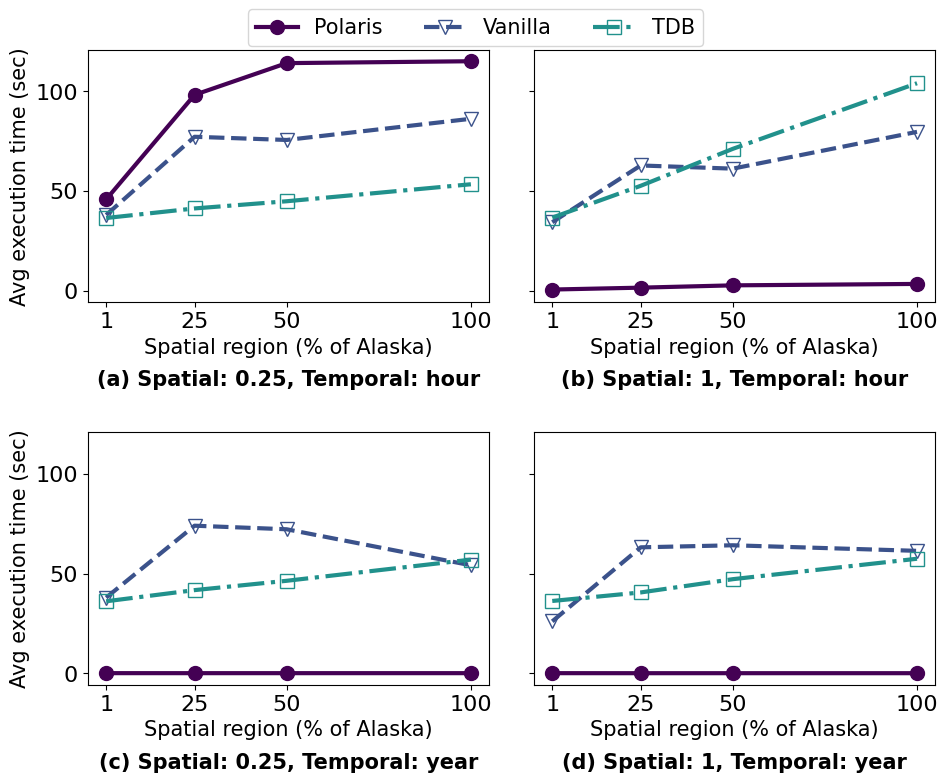

In [18]:
col_name="changing_area"
custom_plot(df_polaris_all,
            df_vanilla_all,
            df_tdb_all,
            timespan_bool=True,
            ticklist=[1, 25, 50, 100],
            ticklabels = [1, 25, 50, 100],
            x_label="Spatial region (% of Alaska)",
            category = get_category(col_name),
            col_name=col_name,
            colsize=10,
            rowsize = 8,
            padding=2.5,
            anchor=(0.5,1.02),
            subtitlesfontsize=15,
            file_name="5a.eps")

# 5b

In [15]:
cur_p = get_res_df(df_polaris_all, [0.25, 1], ["hour", "year"])
cur_v = get_res_df(df_vanilla_all, [0.25, 1], ["hour", "year"])
cur_t = get_res_df(df_tdb_all, [0.25, 1], ["hour", "year"])

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


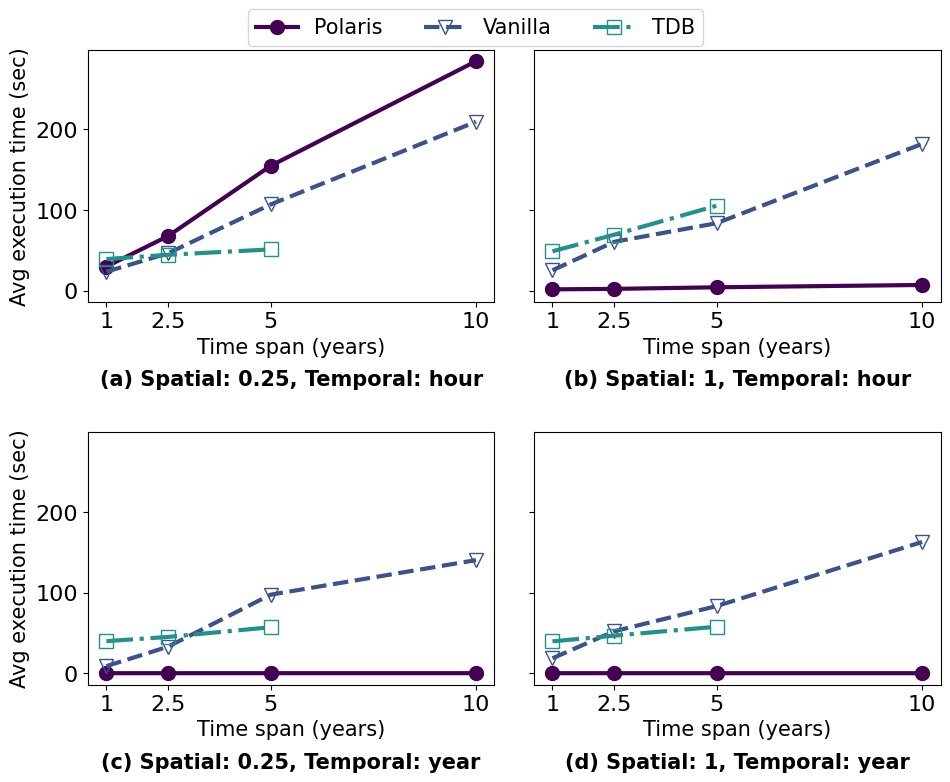

In [19]:
col_name="changing_time"
custom_plot(df_polaris_all,
            df_vanilla_all,
            df_tdb_all,
            timespan_bool=False,
            ticklist=[1, 2.5, 5, 10],
            ticklabels = [1, 2.5, 5, 10],
            x_label="Time span (years)",
            category = get_category(col_name),
            col_name=col_name,
            colsize=10,
            rowsize = 8,
            padding=2.5,
            anchor=(0.5,1.02),
            subtitlesfontsize=15,
            file_name="5b.eps")

# 5c

In [37]:
import matplotlib.pyplot as plt
import matplotlib
import os

def filter_and_process(df, time_span, temporal_res, category):
    filtered_df = df[(df["time_span"] == 5) &
                     (df["temporal_resolution"] == temporal_res)].sort_values(category)
        
    return get_avg_execution_time(filtered_df)

def plot_subplot(ax, df_polaris, df_vanilla, df_tdb, title, ylab, ticklist, ticklabels, x_label, category, subtitlesfontsize):
    # Define colormap
    viridis = matplotlib.colormaps["viridis"]
    colors = [viridis(i) for i in [0, 0.25, 0.5, 0.75]]
    
    # Fixed plot settings
    m_size=12
    ticksize=16
    line_width = 3
    subplotyspacing=-0.3
    below="top"
    subplot_font = "bold"
    xy_label_font = "small-caps"
    y_label="Avg execution time (sec)"
    xlabelfontsize = 15
    
    # Define styles for each dataset
    plot_styles = {
        "Polaris": {"marker": "o", "ms": 10, "fillstyle": "full", "linestyle": "-", "color": colors[0]},
        "Vanilla": {"marker": "v", "ms": 10, "fillstyle": "none", "linestyle": "--", "color": colors[1]},
        "TDB": {"marker": "s", "ms": 10, "fillstyle": "none", "linestyle": "-.", "color": colors[2]}
    }
    
    datasets = {"Polaris": df_polaris, "Vanilla": df_vanilla, "TDB": df_tdb}
    for label, df in datasets.items():
        style = plot_styles[label]
        ax.plot(df[category], df["avg_execution_time"], label=label, 
                color=style["color"], marker=style["marker"], ms=style["ms"], 
                fillstyle=style["fillstyle"], linestyle=style["linestyle"], linewidth=line_width)
    
    ax.set_title(title, fontsize=subtitlesfontsize, fontweight=subplot_font, y=subplotyspacing, va=below)
    ax.tick_params(axis="both", labelsize=ticksize)
    if ticklist is not None:
        ax.set_xticks(ticks=ticklist, labels=ticklabels)
    ax.set_xlabel(x_label, fontsize=xlabelfontsize, fontvariant=xy_label_font)

    if ylab:
        ax.set_ylabel(y_label, fontsize=subtitlesfontsize, fontvariant=xy_label_font)
        
    legend_lines, legend_labels = ax.get_legend_handles_labels()
    ax.legend().remove()
    return legend_lines, legend_labels

def custom_plot(df_polaris_all, df_vanilla_all, df_tdb_all,
                timespan_bool,
                ticklist, ticklabels, x_label, category, 
                col_name, colsize, rowsize, padding, anchor, subtitlesfontsize,
                file_name):

    fig, axs = plt.subplots(2, 2, figsize=(colsize, rowsize), sharey=True)
    
    # Define plot configurations
    plot_configs = [
        ("hour", "(a) Hourly", axs[0, 0], True),
        ("day", "(b) Daily", axs[0, 1], False),
        ("month", "(c) Monthly", axs[1, 0], True),
        ("year", "(d) Yearly", axs[1, 1], False),
    ]
    df_polaris = df_polaris_all[df_polaris_all["category"]==col_name]
    df_vanilla = df_vanilla_all[df_vanilla_all["category"]==col_name]
    df_tdb = df_tdb_all[df_tdb_all["category"]==col_name]
    
    for temporal_res, title, ax, ylab in plot_configs:
        df_polaris_proc = filter_and_process(df_polaris, timespan_bool, temporal_res, category)
        df_vanilla_proc = filter_and_process(df_vanilla, timespan_bool, temporal_res, category)
        df_tdb_proc = filter_and_process(df_tdb, timespan_bool, temporal_res, category)
        
        llines, llabels = plot_subplot(ax, df_polaris_proc, df_vanilla_proc, df_tdb_proc, 
                                       title, ylab, ticklist, ticklabels, x_label, category, subtitlesfontsize)

    fig.legend(llines, llabels, loc='upper center', bbox_to_anchor=anchor, fontsize=subtitlesfontsize, ncols=len(plot_configs))
    fig.tight_layout(pad=padding)
    plt.savefig(os.path.join("/data/experiment-kit/experiment/results/figures/", file_name))
        
    plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


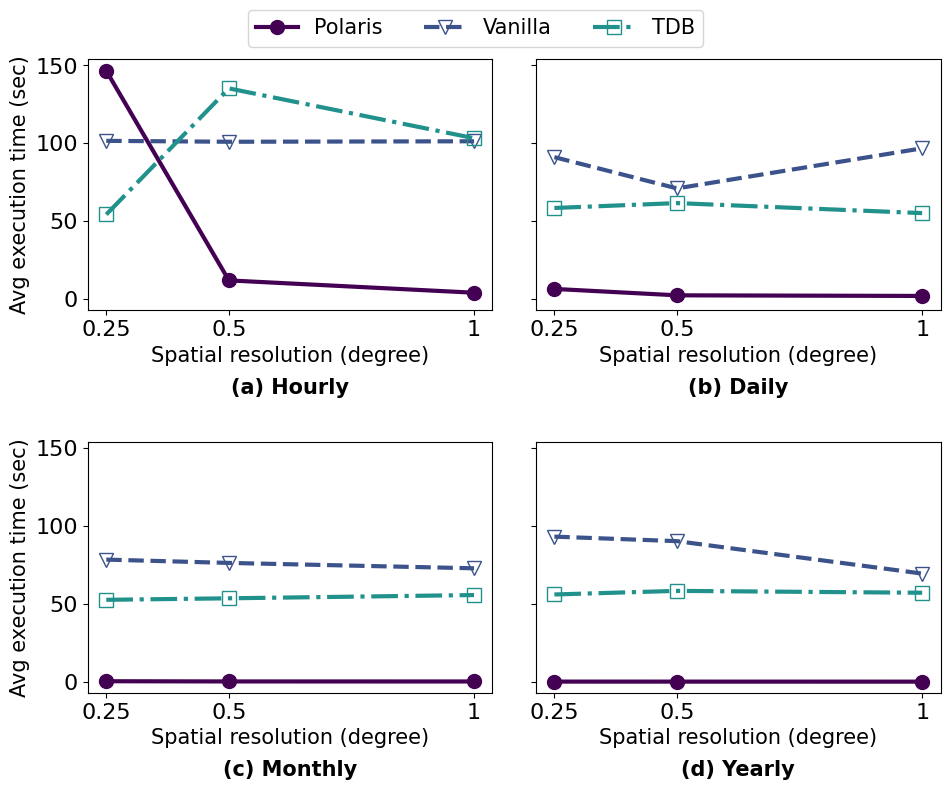

In [39]:
col_name="changing_resolution"
custom_plot(df_polaris_all,
            df_vanilla_all,
            df_tdb_all,
            timespan_bool=True,
            ticklist=[0.25, 0.5, 1],
            ticklabels = [0.25, 0.5, 1],
            x_label="Spatial resolution (degree)",
            category = get_category(col_name),
            col_name=col_name,
            colsize=10,
            rowsize = 8,
            padding=2.5,
            anchor=(0.5,1.03),
            subtitlesfontsize=15,
            file_name="5c.eps")

# 5d

In [78]:
import matplotlib.pyplot as plt
import matplotlib
import os

def filter_and_process(df, time_span, temporal_res, category):
    filtered_df = df[(df["time_span"] == 5) &
                     (df["spatial_resolution"] == temporal_res)].sort_values(category)
        
    return get_avg_execution_time(filtered_df)

def plot_subplot(ax, df_polaris, df_vanilla, df_tdb, title, ylab, ticklist, ticklabels, x_label, category, subtitlesfontsize):
    # Define colormap
    viridis = matplotlib.colormaps["viridis"]
    colors = [viridis(i) for i in [0, 0.25, 0.5, 0.75]]
    
    # Fixed plot settings
    m_size=12
    ticksize=16
    line_width = 3
    subplotyspacing=-0.3
    below="top"
    subplot_font = "bold"
    xy_label_font = "small-caps"
    y_label="Avg execution time (sec)"
    xlabelfontsize = 15
    
    # Define styles for each dataset
    plot_styles = {
        "Polaris": {"marker": "o", "ms": 10, "fillstyle": "full", "linestyle": "-", "color": colors[0]},
        "Vanilla": {"marker": "v", "ms": 10, "fillstyle": "none", "linestyle": "--", "color": colors[1]},
        "TDB": {"marker": "s", "ms": 10, "fillstyle": "none", "linestyle": "-.", "color": colors[2]}
    }
    
    datasets = {"Polaris": df_polaris, "Vanilla": df_vanilla, "TDB": df_tdb}
    for label, df in datasets.items():
        style = plot_styles[label]
        ax.plot(df[category], df["avg_execution_time"], label=label, 
                color=style["color"], marker=style["marker"], ms=style["ms"], 
                fillstyle=style["fillstyle"], linestyle=style["linestyle"], linewidth=line_width)
    
    ax.set_title(title, fontsize=subtitlesfontsize, fontweight=subplot_font, y=subplotyspacing, va=below)
    ax.tick_params(axis="both", labelsize=ticksize)
    if ticklist is not None:
        ax.set_xticks(ticks=ticklist, labels=ticklabels)
    ax.set_xlabel(x_label, fontsize=xlabelfontsize, fontvariant=xy_label_font)

    if ylab:
        ax.set_ylabel(y_label, fontsize=subtitlesfontsize, fontvariant=xy_label_font)
        
    legend_lines, legend_labels = ax.get_legend_handles_labels()
    ax.legend().remove()
    return legend_lines, legend_labels

def custom_plot(df_polaris_all, df_vanilla_all, df_tdb_all,
                timespan_bool,
                ticklist, ticklabels, x_label, category, 
                col_name, colsize, rowsize, padding, anchor, subtitlesfontsize,
                file_name):

    fig, axs = plt.subplots(1, 2, figsize=(colsize, rowsize), sharey=True)
    
    # Define plot configurations
    plot_configs = [
        (0.25, "(a) 0.25 degrees", axs[0], True),
        (1, "(b) 1.0 degrees", axs[1], False)
    ]
    df_polaris = df_polaris_all[df_polaris_all["category"]==col_name]
    df_vanilla = df_vanilla_all[df_vanilla_all["category"]==col_name]
    df_tdb = df_tdb_all[df_tdb_all["category"]==col_name]
    
    for temporal_res, title, ax, ylab in plot_configs:
        df_polaris_proc = filter_and_process(df_polaris, timespan_bool, temporal_res, category)
        df_vanilla_proc = filter_and_process(df_vanilla, timespan_bool, temporal_res, category)
        df_tdb_proc = filter_and_process(df_tdb, timespan_bool, temporal_res, category)
        
        llines, llabels = plot_subplot(ax, df_polaris_proc, df_vanilla_proc, df_tdb_proc, 
                                       title, ylab, ticklist, ticklabels, x_label, category, subtitlesfontsize)

    fig.legend(llines, llabels, loc='upper center', bbox_to_anchor=anchor, fontsize=subtitlesfontsize, ncols=4)
    fig.tight_layout(pad=padding)
    plt.savefig(os.path.join("/data/experiment-kit/experiment/results/figures/", file_name))
        
    plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


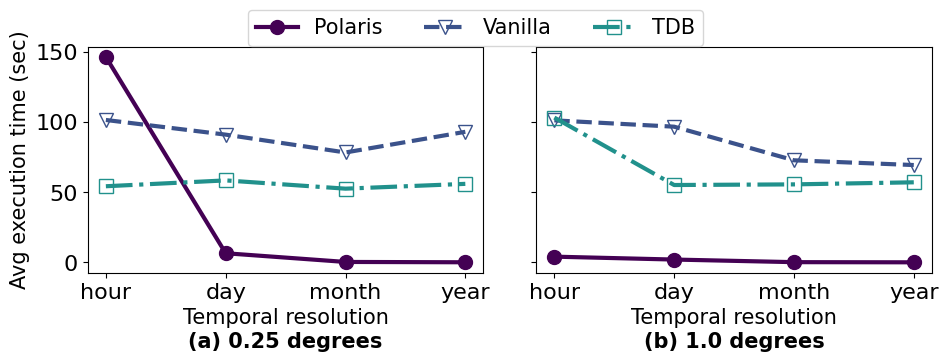

In [79]:
col_name="changing_resolution"
custom_plot(df_polaris_all,
            df_vanilla_all,
            df_tdb_all,
            timespan_bool=True,
            ticklist=[0,1,2,3],
            ticklabels = ["hour", "day", "month", "year"],
            x_label="Temporal resolution",
            category = "temporal_resolution",
            col_name=col_name,
            colsize=10,
            rowsize = 4,
            padding=2.5,
            anchor=(0.5,1.03),
            subtitlesfontsize=15,
            file_name="5d.eps")

In [56]:
for i in range(2):
    print(i)

0
1


### Other

### No for-loops

Text(0.5, 0, 'Spatial region (% of Alaska)')

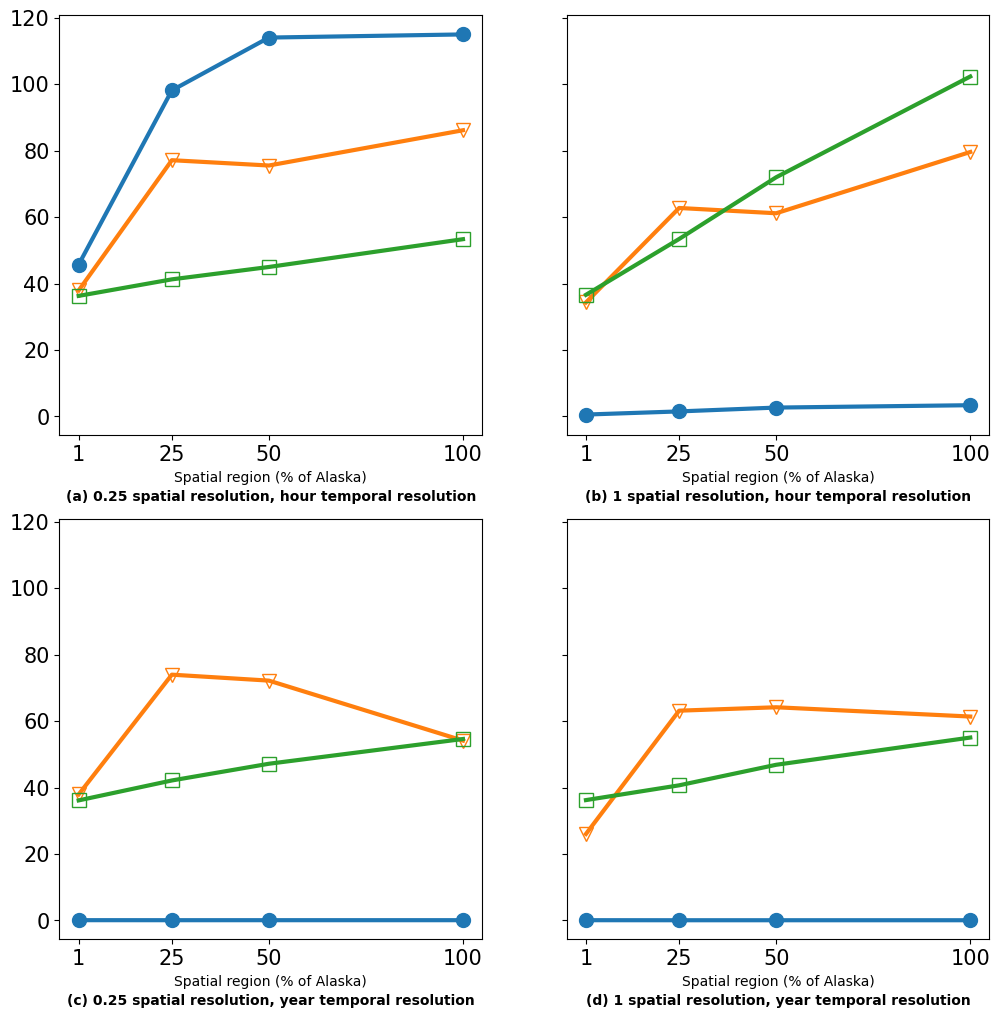

In [10]:
import matplotlib.pyplot as plt

m_size = 10
ticklist = [1, 25, 50, 100]
ticklabels = [1, 25, 50, 100]
ticksize = 15
line_width = 3
subplotyspacing= -0.15
subtitlesfontsize = 10
below = "top"

# plot Figure 5 abcd: changing spatial area
fig, axs = plt.subplots(2, 2, figsize=(12, 12), sharey=True)

# fig a: changing spatial area, 5 years, 0.25 spatial resolution, hour temporal resolution
df_polaris_ = df_polaris[
    (df_polaris["time_span"] == 5)
    & (df_polaris["temporal_resolution"] == "hour")
    & (df_polaris["spatial_resolution"] == 0.25)
].sort_values("area_persent")
df_polaris_a = get_avg_execution_time(df_polaris_)

df_vanilla_ = df_vanilla[
    (df_vanilla["time_span"] == 5)
    & (df_vanilla["temporal_resolution"] == "hour")
    & (df_vanilla["spatial_resolution"] == 0.25)
].sort_values("area_persent")
df_vanilla_a = get_avg_execution_time(df_vanilla_)

df_tdb_ = df_tdb[
    (df_tdb["time_span"] == 5) 
    & (df_tdb["temporal_resolution"] == "hour") 
    & (df_tdb["spatial_resolution"] == 0.25)
].sort_values("area_persent")
df_tdb_a = get_avg_execution_time(df_tdb_)

axs[0, 0].plot(
    df_polaris_a["area_persent"], df_polaris_a["avg_execution_time"], label="Polaris", marker="o", ms=m_size, fillstyle="full", linestyle="-", linewidth=line_width)

axs[0, 0].plot(
    df_vanilla_a["area_persent"], df_vanilla_a["avg_execution_time"], label="Vanilla", marker="v", ms=m_size, fillstyle="none", linestyle="-", linewidth=line_width)

axs[0, 0].plot(
    df_tdb_a["area_persent"], df_tdb_a["avg_execution_time"], label="TDB", marker="s", ms=m_size, fillstyle="none", linestyle="-", linewidth=line_width)

axs[0, 0].set_title("(a) 0.25 spatial resolution, hour temporal resolution",  fontsize=subtitlesfontsize, fontweight='bold', y=subplotyspacing, va=below)
axs[0, 0].tick_params(axis="both", labelsize=ticksize)
if ticklist is not None:
    axs[0, 0].set_xticks(ticks=ticklist, labels=ticklabels)
axs[0, 0].set_xlabel("Spatial region (% of Alaska)")

# fig b: changing spatial area, 5 years, 1 spatial resolution, hour temporal resolution
df_polaris_ = df_polaris[
    (df_polaris["time_span"] == 5)
    & (df_polaris["temporal_resolution"] == "hour")
    & (df_polaris["spatial_resolution"] == 1)
].sort_values("area_persent")
df_polaris_b = get_avg_execution_time(df_polaris_)

df_vanilla_ = df_vanilla[
    (df_vanilla["time_span"] == 5)
    & (df_vanilla["temporal_resolution"] == "hour")
    & (df_vanilla["spatial_resolution"] == 1)
].sort_values("area_persent")
df_vanilla_b = get_avg_execution_time(df_vanilla_)


df_tdb_ = df_tdb[
    (df_tdb["time_span"] == 5) 
    & (df_tdb["temporal_resolution"] == "hour") 
    & (df_tdb["spatial_resolution"] == 1)
].sort_values("area_persent")
df_tdb_b = get_avg_execution_time(df_tdb_)


axs[0, 1].plot(df_polaris_b["area_persent"], df_polaris_b["avg_execution_time"], label="Polaris", marker="o", ms=m_size, fillstyle="full", linestyle="-", linewidth=line_width)
axs[0, 1].plot(df_vanilla_b["area_persent"], df_vanilla_b["avg_execution_time"], label="Vanilla", marker="v", ms=m_size, fillstyle="none", linestyle="-", linewidth=line_width)
axs[0, 1].plot(df_tdb_b["area_persent"], df_tdb_b["avg_execution_time"], label="TDB", marker="s", ms=m_size, fillstyle="none", linestyle="-", linewidth=line_width)

axs[0, 1].set_title("(b) 1 spatial resolution, hour temporal resolution", fontsize=subtitlesfontsize, fontweight='bold', y=subplotyspacing, va=below)
axs[0, 1].tick_params(axis="both", labelsize=ticksize)
if ticklist is not None:
    axs[0, 1].set_xticks(ticks=ticklist, labels=ticklabels)
axs[0, 1].set_xlabel("Spatial region (% of Alaska)")

# fig c: changing spatial area, 5 years, 0.25 spatial resolution, year temporal resolution
df_polaris_ = df_polaris[
    (df_polaris["time_span"] == 5)
    & (df_polaris["temporal_resolution"] == "year")
    & (df_polaris["spatial_resolution"] == 0.25)
].sort_values("area_persent")
df_polaris_c = get_avg_execution_time(df_polaris_)

df_vanilla_ = df_vanilla[
    (df_vanilla["time_span"] == 5)
    & (df_vanilla["temporal_resolution"] == "year")
    & (df_vanilla["spatial_resolution"] == 0.25)
].sort_values("area_persent")
df_vanilla_c = get_avg_execution_time(df_vanilla_)

df_tdb_ = df_tdb[
    (df_tdb["time_span"] == 5) 
    & (df_tdb["temporal_resolution"] == "year") 
    & (df_tdb["spatial_resolution"] == 0.25)
].sort_values("area_persent")
df_tdb_c = get_avg_execution_time(df_tdb_)

axs[1, 0].plot(df_polaris_c["area_persent"], df_polaris_c["avg_execution_time"], label="Polaris", marker="o", ms=m_size, fillstyle="full", linestyle="-", linewidth=line_width)
axs[1, 0].plot(df_vanilla_c["area_persent"], df_vanilla_c["avg_execution_time"], label="Vanilla",  marker="v", ms=m_size, fillstyle="none", linestyle="-", linewidth=line_width)
axs[1, 0].plot(df_tdb_c["area_persent"], df_tdb_c["avg_execution_time"], label="TDB", marker="s", ms=m_size, fillstyle="none", linestyle="-", linewidth=line_width)

axs[1, 0].set_title("(c) 0.25 spatial resolution, year temporal resolution", fontsize=subtitlesfontsize, fontweight='bold', y=subplotyspacing, va=below)
axs[1, 0].tick_params(axis="both", labelsize=ticksize)
if ticklist is not None:
    axs[1, 0].set_xticks(ticks=ticklist, labels=ticklabels)
axs[1, 0].set_xlabel("Spatial region (% of Alaska)")

# fig d: changing spatial area, 5 years, 1 spatial resolution, year temporal resolution
df_polaris_ = df_polaris[
    (df_polaris["time_span"] == 5)
    & (df_polaris["temporal_resolution"] == "year")
    & (df_polaris["spatial_resolution"] == 1)
].sort_values("area_persent")
df_polaris_d = get_avg_execution_time(df_polaris_)

df_vanilla_ = df_vanilla[
    (df_vanilla["time_span"] == 5)
    & (df_vanilla["temporal_resolution"] == "year")
    & (df_vanilla["spatial_resolution"] == 1)
].sort_values("area_persent")
df_vanilla_d = get_avg_execution_time(df_vanilla_)

df_tdb_ = df_tdb[
    (df_tdb["time_span"] == 5) 
    & (df_tdb["temporal_resolution"] == "year") 
    & (df_tdb["spatial_resolution"] == 1)
].sort_values("area_persent")
df_tdb_d = get_avg_execution_time(df_tdb_)

axs[1, 1].plot(df_polaris_d["area_persent"], df_polaris_d["avg_execution_time"], label="Polaris", marker="o", ms=m_size, fillstyle="full", linestyle="-", linewidth=line_width)
axs[1, 1].plot(df_vanilla_d["area_persent"], df_vanilla_d["avg_execution_time"], label="Vanilla", marker="v", ms=m_size, fillstyle="none", linestyle="-", linewidth=line_width)
axs[1, 1].plot(df_tdb_d["area_persent"], df_tdb_d["avg_execution_time"], label="TDB", marker="s", ms=m_size, fillstyle="none", linestyle="-", linewidth=line_width)

axs[1, 1].set_title("(d) 1 spatial resolution, year temporal resolution", fontsize=subtitlesfontsize, fontweight='bold', y=subplotyspacing, va=below)
axs[1, 1].tick_params(axis="both", labelsize=ticksize)
if ticklist is not None:
    axs[1, 1].set_xticks(ticks=ticklist, labels=ticklabels)
axs[1, 1].set_xlabel("Spatial region (% of Alaska)")

### Original Custom Plots Function

In [ ]:
import matplotlib.pyplot as plt

def custom_plot(df1, df2, df3, df4, 
                df3bool, df4bool, 
                nrows, ncols, 
                rowsize, colsize, 
                labsx, labsy, linearbool, ticksize, ticklist, ticklabels,
                subtitles, subtitlesfontsize, subplotyspacing,
                figtitle, figtitlefontsize, 
                categories, barlegendbool, 
                markernames, markersize, markerfills, 
                systemnames, linestyles, linewidth, 
                padding, anchor):
    
    fig, axs = plt.subplots(nrows, ncols, figsize=(colsize, rowsize), sharey=True)
    
    if nrows + ncols > 2:
        axs = axs.flatten()

        for i, (category, x_lab) in enumerate(zip(categories, labsx)):
            df1_cat = df1[df1["category"] == category]  # proposed
            df2_cat = df2[df2["category"] == category]  # vanilla

            df_list = [df1_cat, df2_cat]

            if df3bool: #cloud
                df3_cat = df3[df3["category"] == category]
                df_list.append(df3_cat)
            if df4bool: # tiledb
                df4_cat = df4[df4["category"] == category]
                df_list.append(df4_cat)

            x_col = cj["general"]["x_col"][category]

            if not linearbool:
                axs[i].set_yscale("log", base=10)

            customizations = zip(df_list, systemnames, markernames, markerfills, linestyles)
            
            for df, s_name, m_name, m_fill, l_style, in customizations:

                # plot each system's line
                axs[i].plot(df[x_col], df["avg_execution_time"], label=s_name, 
                                marker=m_name, ms=markersize, fillstyle=m_fill, linestyle=l_style)
            
            # set subplot axis params
            axs[i].tick_params(axis="both", labelsize=ticksize)

            if ticklist is not None:
                axs[i].set_xticks(ticks=ticklist[i], labels=ticklabels[i])
            axs[i].set_title(subtitles[i], fontsize=subtitlesfontsize, fontweight='bold', y=subplotyspacing, va=cj["genera"]["below"])
            axs[i].set_xlabel(x_lab, )